In [1]:
library(plyr)
library(tidyverse)
library(ggpubr)
library(plotly)
library(caret)
library(htmlwidgets)
source("utils/plot_theme.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘ggpubr’


The following ob

In [2]:
enrichr_adj_pval_thresh = 0.05


In [3]:
#geneSets_DF = read_delim(file = "data/omics_revamped_LLM_Enrichr_simVals_failure_refs_DF.tsv",
#                         delim = "\t")
geneSets_DF = read_delim(file = "data/omics_revamped_LLM_Enrichr_simVals_failure_240625_maxAPV_DF.tsv",
                         delim = "\t")

Rows: 300 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (12): Source, GeneSetID, GeneSetName, GeneList, LLM Name, LLM Analysis, ...
dbl (10): ...1, Unnamed: 0, n_Genes, Score, Rank, P-value, Adjusted P-value,...
lgl  (2): LLM_success_TF, enrichr_success_TF

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
geneSets_DF$LLM_success_TF = as.factor(geneSets_DF$LLM_success_TF)

In [5]:
JI_threshList = seq(0, 1, 0.05) #seq(0, 1, 0.01)

In [6]:
JI_thresh_eval_DF = data_frame(JI_thresh = JI_threshList, perc_success = NaN, accuracy = NaN, perc_meetsThresh = NaN)

Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.”


In [7]:
for (JI_threshInd in c(1:length(JI_threshList))){
    JI_thresh = JI_threshList[JI_threshInd]
    
    JI_threshCol = ((geneSets_DF$`Adjusted P-value` <= enrichr_adj_pval_thresh) & (geneSets_DF$enrichr_JI >= JI_thresh)) 

    JI_thresh_eval_DF$perc_success[JI_threshInd] = sum(JI_threshCol)/nrow(geneSets_DF)
    
    JI_threshOnlyCol = (geneSets_DF$enrichr_JI >= JI_thresh) 

    JI_thresh_eval_DF$perc_meetsThresh[JI_threshInd] = 100*sum(JI_threshOnlyCol)/nrow(geneSets_DF)
    
    
    JI_threshCol = JI_threshCol %>% as.factor()
    
    if (nlevels(JI_threshCol) == 1){next}
    
    c = confusionMatrix(JI_threshCol, geneSets_DF$LLM_success_TF)
   # print(c)
    JI_thresh_eval_DF$accuracy[JI_threshInd] = c$overall["Accuracy"]
    
    }

In [8]:
JI_thresh_eval_DF

JI_thresh,perc_success,accuracy,perc_meetsThresh
<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.733333333,0.6033333,100.0000000
0.05,0.353333333,0.6900000,36.0000000
0.10,0.133333333,0.6633333,13.3333333
0.15,0.033333333,0.5833333,3.3333333
0.20,0.010000000,0.5666667,1.0000000
0.25,0.006666667,0.5633333,0.6666667
0.30,0.000000000,NaN,0.0000000
0.35,0.000000000,NaN,0.0000000
0.40,0.000000000,NaN,0.0000000


In [9]:
g2 = ggscatter(data = JI_thresh_eval_DF,
          x = "JI_thresh",
          y = "perc_meetsThresh", 
          xlab = "Required overlap with enriched GO terms",
        ylab = "Percentage of omics gene sets with required overlap with GO") +
geom_line()+
geom_vline(xintercept = 0.1, color = "red", linetype="dotted")+
theme_pubr()

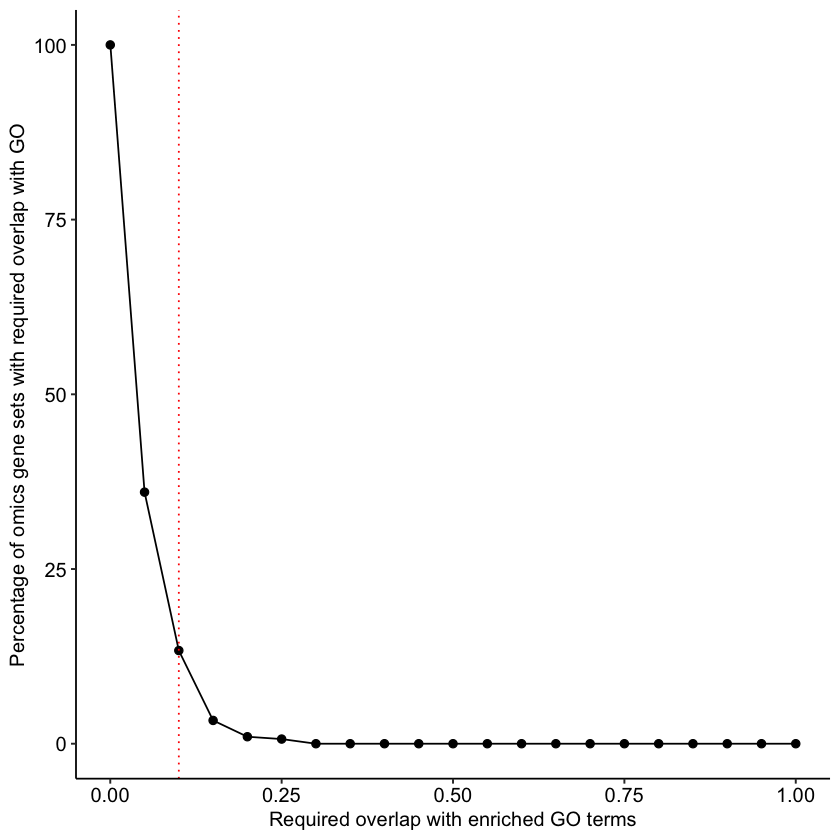

In [10]:
g2


In [11]:
ggsave(filename = "figures/OmicsRevamped_Enrichment_success_onlyThreshold_240625_best_APV.png", plot = g2,width = 5, height = 3)

In [12]:
ggsave(filename = "figures/OmicsRevamped_Enrichment_success_onlyThreshold_240613_best_APV.svg", plot = g2,width = 5, height = 3)

In [13]:
geneSets_DF$enrichr_success_TF_0.1 = ((geneSets_DF$`Adjusted P-value` <= enrichr_adj_pval_thresh) & (geneSets_DF$enrichr_JI >= 0.1)) 

In [14]:
write_delim(x = geneSets_DF, file = "data/omics_revamped_LLM_Enrichr_simVals_failure_refs_240613_best_APV_DF.tsv" , 
            delim = "\t")

In [ ]:
table(geneSets_DF[,c("enrichr_success_TF_0.1", "LLM_success_TF")])
      